In [16]:
import pandas as pd
import numpy as np
import pandas_datareader as reader
import matplotlib.pyplot as plt
from scipy import stats


In [17]:
# Training set with 10 stocks

tickers = ["AAPL", "AMZN", "BRK-B", "GOOG", "JNJ", "MSFT", 
           "NFLX", "NVDA", "TSLA", "V"]
training_data = reader.get_data_yahoo(tickers, start = "2018-11-07", end = "2020-03-06")

training_daily_returns = training_data['Adj Close'].pct_change().dropna()


training_mean = training_daily_returns.mean().to_frame().to_numpy()
training_std = training_daily_returns.std().to_frame().to_numpy()
training_cov = training_daily_returns.cov().to_numpy()

print(training_daily_returns)
print(training_mean)
print(training_cov)



Symbols         AAPL      AMZN     BRK-B      GOOG       JNJ      MSFT  \
Date                                                                     
2018-11-08 -0.003489 -0.000330  0.005334 -0.010051  0.003800 -0.001876   
2018-11-09 -0.019282 -0.024206 -0.012544 -0.015013  0.000275 -0.019508   
2018-11-12 -0.050374 -0.044136 -0.019169 -0.025813  0.001926 -0.024642   
2018-11-13 -0.009991 -0.003470  0.011605 -0.002484 -0.006455  0.000655   
2018-11-14 -0.028247 -0.019716 -0.008673  0.007345 -0.002972 -0.014181   
...              ...       ...       ...       ...       ...       ...   
2020-03-02  0.093101  0.037266  0.054716  0.037168  0.041196  0.066539   
2020-03-03 -0.031759 -0.023010 -0.040528 -0.034353 -0.031638 -0.047919   
2020-03-04  0.046385  0.035013  0.043341  0.033644  0.058190  0.036715   
2020-03-05 -0.032437 -0.026217 -0.040852 -0.048669 -0.010245 -0.025095   
2020-03-06 -0.013280 -0.011923 -0.014261 -0.015640  0.000141 -0.028267   

Symbols         NFLX      NVDA      T

In [18]:
# Training set S&P 500

sp500 = ["^GSPC"]
training_sp = reader.get_data_yahoo(sp500, start = "2018-11-07", end = "2020-03-06")

training_daily_returns_sp = training_sp['Adj Close'].pct_change().dropna()

training_mean_sp = training_daily_returns_sp.mean().item()
training_std_sp = training_daily_returns_sp.std().item()
training_cumu_sp = np.prod(1 + training_daily_returns_sp) - 1

print(training_daily_returns_sp)
print(training_mean_sp)
print(training_std_sp)


Symbols        ^GSPC
Date                
2018-11-08 -0.002509
2018-11-09 -0.009199
2018-11-12 -0.019701
2018-11-13 -0.001482
2018-11-14 -0.007567
...              ...
2020-03-02  0.046039
2020-03-03 -0.028108
2020-03-04  0.042203
2020-03-05 -0.033922
2020-03-06 -0.017054

[332 rows x 1 columns]
0.00022045456770344762
0.010534871218494243


In [19]:
# Training set risk free (10-yr T-bill)

tbill = ["^TNX"]

training_tbill = reader.get_data_yahoo(tbill, start = "2018-11-07", end = "2020-03-06")['Adj Close'].dropna()/100/252

training_rf = training_daily_returns_sp.join(training_tbill).drop(columns="^GSPC").fillna(0)

training_mean_rf = training_rf.mean().item()

print(training_rf)


Symbols         ^TNX
Date                
2018-11-08  0.000128
2018-11-09  0.000127
2018-11-12  0.000126
2018-11-13  0.000125
2018-11-14  0.000124
...              ...
2020-03-02  0.000043
2020-03-03  0.000040
2020-03-04  0.000039
2020-03-05  0.000037
2020-03-06  0.000028

[332 rows x 1 columns]


In [20]:
# Training set 1/N

w_N = np.ones(10)/10
training_daily_returns_N = training_daily_returns.dot(w_N)


training_mean_N = training_daily_returns_N.mean()
training_std_N = training_daily_returns_N.std()
training_cumu_N = np.prod(1 + training_daily_returns_N) - 1

print(training_daily_returns_N)
print(training_mean_N)
print(training_std_N)

Date
2018-11-08   -0.005994
2018-11-09   -0.014877
2018-11-12   -0.035572
2018-11-13    0.006502
2018-11-14   -0.008922
                ...   
2020-03-02    0.055748
2020-03-03   -0.031134
2020-03-04    0.041549
2020-03-05   -0.032267
2020-03-06   -0.016295
Length: 332, dtype: float64
0.0009043158804040512
0.01476064859256022


In [21]:
def get_opt(tau, mean, cov, ticker_count):
    
    e = np.ones((ticker_count, 1))
    
    w_z = np.subtract(np.dot(np.linalg.inv(cov), mean),
                      np.dot(np.divide(np.dot(np.dot(e.T, np.linalg.inv(cov)), mean),
                                       np.dot(np.dot(e.T, np.linalg.inv(cov)), e)).item(), 
                             np.dot(np.linalg.inv(cov), e)))

    w_m = np.divide(np.dot(np.linalg.inv(cov), e),
                    np.dot(np.dot(e.T, np.linalg.inv(cov)), e).item())    
    return np.add(np.dot(tau, w_z), w_m)


In [22]:
def get_mu(w, mean):
    return np.dot(w.T, mean)

def get_sigma(w, cov):
    return np.dot(np.dot(w.T, cov), w)

def get_beta(ra, rf, rm):
    y = np.subtract(ra, rf).to_numpy().T.flatten()
    x = np.subtract(rm, rf).to_numpy().T.flatten()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope


[[-0.19549528]
 [ 0.04286301]
 [ 0.56774609]
 [ 0.13766348]
 [ 0.39386736]
 [-0.08553193]
 [-0.01607604]
 [-0.04495882]
 [ 0.006641  ]
 [ 0.19328113]]
[[ 0.20006615]
 [-0.37516828]
 [-0.59864542]
 [ 0.11163183]
 [ 0.43745586]
 [ 0.86564907]
 [-0.09419943]
 [-0.02858744]
 [ 0.14208676]
 [ 0.33971089]]
[[ 0.59562758]
 [-0.79319957]
 [-1.76503693]
 [ 0.08560019]
 [ 0.48104435]
 [ 1.81683007]
 [-0.17232281]
 [-0.01221605]
 [ 0.27753251]
 [ 0.48614065]]
[[ 0.99118901]
 [-1.21123085]
 [-2.93142844]
 [ 0.05956855]
 [ 0.52463285]
 [ 2.76801107]
 [-0.25044619]
 [ 0.00415533]
 [ 0.41297826]
 [ 0.63257041]]


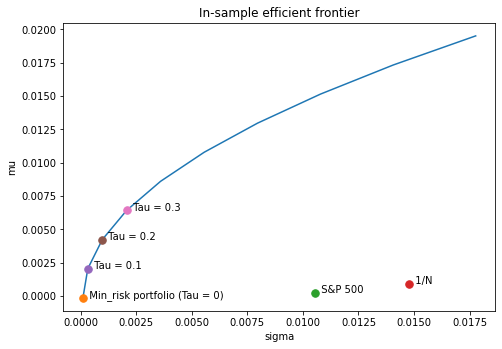

In [23]:
in_sample_mu = np.array([])
in_sample_sigma = np.array([])

for i in range(0, 10, 1):
    tau = i/10
    w_opt = get_opt(tau, training_mean, training_cov, 10)
    new_mu = get_mu(w_opt, training_mean)
    new_sigma = get_sigma(w_opt, training_cov)
    if tau == 0:
        in_sample_min_risk_mu = new_mu.item()
        in_sample_min_risk_sigma = new_sigma.item()
        print(w_opt)
    in_sample_mu = np.append(in_sample_mu, new_mu)
    in_sample_sigma = np.append(in_sample_sigma, new_sigma)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# Efficient Frontier
ax.plot(in_sample_sigma, in_sample_mu)
ax.set_xlabel("sigma")
ax.set_ylabel("mu")
ax.set_title("In-sample efficient frontier")
# Min-risk portfolio
ax.plot(in_sample_min_risk_sigma, in_sample_min_risk_mu, marker=".", markersize=15)
ax.text(in_sample_min_risk_sigma, in_sample_min_risk_mu, "  Min_risk portfolio (Tau = 0)")
# S&P 500
ax.plot(training_std_sp, training_mean_sp, marker=".", markersize=15)
ax.text(training_std_sp, training_mean_sp, "  S&P 500")

# 1/N
ax.plot(training_std_N, training_mean_N, marker=".", markersize=15)
ax.text(training_std_N, training_mean_N, "  1/N")
# Optimal Portfolios
for i in range(1, 4, 1):
    tau = i/10
    w_opt = get_opt(tau, training_mean, training_cov, 10)
    new_mu = get_mu(w_opt, training_mean)
    new_sigma = get_sigma(w_opt, training_cov)
    ax.plot(new_sigma, new_mu, marker=".", markersize=15)
    ax.text(new_sigma, new_mu, "  Tau = "+ str(tau))
    print(w_opt)
plt.show()


In [24]:
print("Portfolio" + "\tMean\t" + "\tStdard Dev." + "\tCumulative" + "\tSharpe Ratio" + "\tTreynor Ratio" + "\tJensen's Alpha")

beta_sp = get_beta(training_daily_returns_sp, training_rf, training_daily_returns_sp)
alpha_sp = (training_mean_sp - training_mean_rf) - beta_sp * (training_mean_sp - training_mean_rf)
print(alpha_sp)
print("S&P 500 \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f" % (training_mean_sp, 
                                                           training_std_sp, 
                                                           training_cumu_sp, 
                                                           (training_mean_sp - training_mean_rf)/training_std_sp,
                                                           (training_mean_sp - training_mean_rf)/beta_sp, 
                                                           alpha_sp))

beta_N = get_beta(training_daily_returns_N.to_frame(), training_rf, training_daily_returns_sp)
alpha_N = (training_mean_N - training_mean_rf) - beta_N * (training_mean_sp - training_mean_rf)
print("1/N\t \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f" % (training_mean_N, 
                                                         training_std_N, 
                                                         training_cumu_N,
                                                         (training_mean_N - training_mean_rf)/training_std_N, 
                                                         (training_mean_N - training_mean_rf)/beta_N, 
                                                         alpha_N))
for i in range(0, 4, 1):
    tau = i/10
    w_opt = get_opt(tau, training_mean, training_cov, 10)
    new_mu = get_mu(w_opt, training_mean)
    new_sigma = get_sigma(w_opt, training_cov)
    new_cumu = np.prod(1 + np.dot(training_daily_returns, w_opt)) - 1
    beta = get_beta(np.dot(training_daily_returns, w_opt), training_rf, training_daily_returns_sp)
    alpha = (new_mu - training_mean_rf) - beta * (training_mean_sp - training_mean_rf)
    print("Tau = %0.1f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f" % (tau, 
                                                                   new_mu, 
                                                                   new_sigma, 
                                                                   new_cumu, 
                                                                   (new_mu - training_mean_rf)/new_sigma,
                                                                   (new_mu - training_mean_rf)/beta, 
                                                                   alpha))

Portfolio	Mean		Stdard Dev.	Cumulative	Sharpe Ratio	Treynor Ratio	Jensen's Alpha
0.0
S&P 500 	0.0002205 	0.0105349 	0.0563207 	0.0129802 	0.0001367 	0.0000000
1/N	 	0.0009043 	0.0147606 	0.3022018 	0.0555942 	0.0006472 	0.0006472
Tau = 0.0 	-0.0001413 	0.0000977 	-0.0611504 	-2.3031704 	-0.0003090 	-0.0003246
Tau = 0.1 	0.0020412 	0.0003160 	0.8676482 	6.1956050 	0.0016016 	0.0017904
Tau = 0.2 	0.0042238 	0.0009707 	2.4519884 	4.2649599 	0.0024122 	0.0039054
Tau = 0.3 	0.0064063 	0.0020620 	4.9292589 	3.0662691 	0.0028604 	0.0060203


In [25]:

################################## TEST ################################################################


In [26]:
# test data 10 stocks
test_data = reader.get_data_yahoo(tickers, start = "2020-3-07", end = "2020-11-06")

test_daily_returns = test_data['Adj Close'].pct_change().dropna()


test_mean = test_daily_returns.mean().to_frame().to_numpy()
test_std = test_daily_returns.std().to_frame().to_numpy()
test_cov = test_daily_returns.cov().to_numpy()

print(test_daily_returns)


Symbols         AAPL      AMZN     BRK-B      GOOG       JNJ      MSFT  \
Date                                                                     
2020-03-10  0.072022  0.050655  0.049707  0.053333  0.038112  0.068384   
2020-03-11 -0.034731 -0.037509 -0.039905 -0.050750 -0.069472 -0.045302   
2020-03-12 -0.098755 -0.079221 -0.095921 -0.082688 -0.048483 -0.094838   
2020-03-13  0.119808  0.064648  0.116099  0.094017  0.070808  0.142169   
2020-03-16 -0.128647 -0.053697 -0.094857 -0.111008 -0.053317 -0.147390   
...              ...       ...       ...       ...       ...       ...   
2020-11-02 -0.000827 -0.010431  0.011937  0.003097  0.011524 -0.000691   
2020-11-03  0.015354  0.014621  0.011355  0.014871 -0.001370  0.020264   
2020-11-04  0.040837  0.063230 -0.002226  0.059944  0.006498  0.048249   
2020-11-05  0.035494  0.024942  0.006208  0.008141  0.002583  0.031887   
2020-11-06 -0.001136 -0.003200  0.006749 -0.000919  0.017816  0.001926   

Symbols         NFLX      NVDA      T

In [27]:
# test data S&P 500
test_sp = reader.get_data_yahoo(sp500, start = "2020-3-07", end = "2020-11-06")

test_daily_returns_sp = test_sp['Adj Close'].pct_change().dropna()

test_mean_sp = test_daily_returns_sp.mean().item()
test_std_sp = test_daily_returns_sp.std().item()
test_cumu_sp = np.prod(1 + test_daily_returns_sp) - 1

print(test_daily_returns_sp)

Symbols        ^GSPC
Date                
2020-03-10  0.049396
2020-03-11 -0.048868
2020-03-12 -0.095113
2020-03-13  0.092871
2020-03-16 -0.119841
...              ...
2020-11-02  0.012318
2020-11-03  0.017799
2020-11-04  0.022047
2020-11-05  0.019460
2020-11-06 -0.000288

[170 rows x 1 columns]


In [28]:
#test data T-bill
test_tbill = reader.get_data_yahoo(tbill, start = "2020-3-07", end = "2020-11-06")['Adj Close'].dropna()/100/252

test_rf = test_daily_returns_sp.join(test_tbill).drop(columns="^GSPC").fillna(0)

test_mean_rf = test_rf.mean().item()

print(test_rf)

Symbols         ^TNX
Date                
2020-03-10  0.000030
2020-03-11  0.000033
2020-03-12  0.000034
2020-03-13  0.000038
2020-03-16  0.000029
...              ...
2020-11-02  0.000034
2020-11-03  0.000035
2020-11-04  0.000030
2020-11-05  0.000031
2020-11-06  0.000033

[170 rows x 1 columns]


In [29]:
# 1/N strategy
test_daily_returns_N = test_daily_returns.dot(w_N)


test_mean_N = test_daily_returns_N.mean()
test_std_N = test_daily_returns_N.std()
test_cumu_N = np.prod(1 + test_daily_returns_N) - 1

print(test_daily_returns_N)

Date
2020-03-10    0.057527
2020-03-11   -0.044270
2020-03-12   -0.091194
2020-03-13    0.086126
2020-03-16   -0.120608
                ...   
2020-11-02    0.008476
2020-11-03    0.019426
2020-11-04    0.031901
2020-11-05    0.022916
2020-11-06    0.003713
Length: 170, dtype: float64


In [31]:
print("Portfolio" + "\tMean\t" + "\tStdard Dev." + "\tCumulative" + "\tSharpe Ratio" + "\tTreynor Ratio" + "\tJensen's Alpha")

beta_sp = get_beta(test_daily_returns_sp, test_rf, test_daily_returns_sp)
alpha_sp = (test_mean_sp - test_mean_rf) - beta_sp * (test_mean_sp - test_mean_rf)
print(alpha_sp)
print("S&P 500 \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f" % (test_mean_sp, 
                                                           test_std_sp, 
                                                           test_cumu_sp, 
                                                           (test_mean_sp - test_mean_rf)/test_std_sp,
                                                           (test_mean_sp - test_mean_rf)/beta_sp, 
                                                           alpha_sp))

beta_N = get_beta(test_daily_returns_N.to_frame(), test_rf, test_daily_returns_sp)
alpha_N = (test_mean_N - test_mean_rf) - beta_N * (test_mean_sp - test_mean_rf)
print("1/N\t \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f" % (test_mean_N, 
                                                         test_std_N, 
                                                         test_cumu_N,
                                                         (test_mean_N - test_mean_rf)/test_std_N, 
                                                         (test_mean_N - test_mean_rf)/beta_N, 
                                                         alpha_N))
for i in range(0, 4, 1):
    tau = i/10
    w_opt = get_opt(tau, training_mean, training_cov, 10)
    new_mu = get_mu(w_opt, test_mean)
    new_sigma = get_sigma(w_opt, test_cov)
    new_cumu = np.prod(1 + np.dot(test_daily_returns, w_opt)) - 1
    beta = get_beta(np.dot(test_daily_returns, w_opt), test_rf, test_daily_returns_sp)
    alpha = (new_mu - test_mean_rf) - beta * (test_mean_sp - test_mean_rf)
    print("Tau = %0.1f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f \t%0.7f" % (tau, 
                                                                   new_mu, 
                                                                   new_sigma, 
                                                                   new_cumu, 
                                                                   (new_mu - test_mean_rf)/new_sigma,
                                                                   (new_mu - test_mean_rf)/beta, 
                                                                   alpha))

Portfolio	Mean		Stdard Dev.	Cumulative	Sharpe Ratio	Treynor Ratio	Jensen's Alpha
0.0
S&P 500 	0.0017353 	0.0241515 	0.2777583 	0.0707000 	0.0017075 	0.0000000
1/N	 	0.0033683 	0.0254569 	0.6761813 	0.1312205 	0.0034550 	0.0016896
Tau = 0.0 	0.0001393 	0.0004530 	-0.0145012 	0.2461493 	0.0001444 	-0.0012072
Tau = 0.1 	0.0031473 	0.0012354 	0.5366314 	2.5250726 	0.0024732 	0.0009657
Tau = 0.2 	0.0061552 	0.0033210 	1.1371552 	1.8450175 	0.0035007 	0.0031387
Tau = 0.3 	0.0091632 	0.0067099 	1.6393663 	1.3614625 	0.0040795 	0.0053117
